In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import librosa
import torchaudio.functional as F
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Audio, display

import augmentations.misc as misc

In [2]:
def audio_to_melspectrogram(audio, sampling_rate, hop_length=256, n_fft=2048):
    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sampling_rate, hop_length=hop_length, n_fft=n_fft
    )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(
    spectrogram, sampling_rate, title="log-frequency power spectrogram"
):
    librosa.display.specshow(spectrogram, x_axis="time", y_axis="mel", sr=sampling_rate)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()


def show_signal(audio):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


def show_and_play_signal(audio, sample_rate):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()
    display(Audio(audio, rate=sample_rate))


def read_as_melspectrogram(file_path):
    audio, sampling_rate = misc.load_audio(file_path)
    spectrogram = audio_to_melspectrogram(audio, sampling_rate)
    return spectrogram

In [3]:
from torchaudio.utils import download_asset


SAMPLE_SPEECH = download_asset(
    "tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav"
)
SAMPLE_NOISE = download_asset(
    "tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav"
)

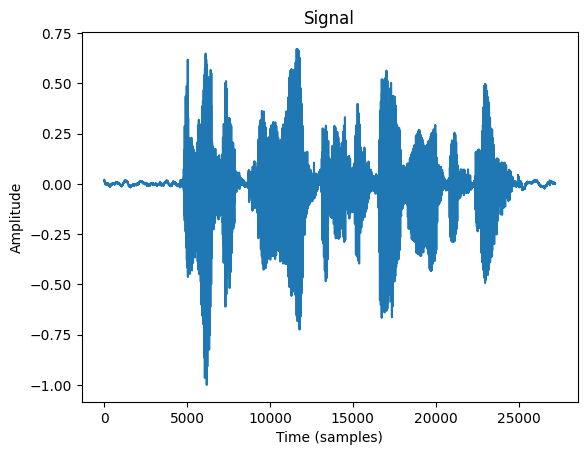

In [4]:
waveform, sample_rate = misc.load_audio(SAMPLE_SPEECH)
show_and_play_signal(waveform, sample_rate)

In [5]:
from augmentations import RandomRIR


aug = RandomRIR()

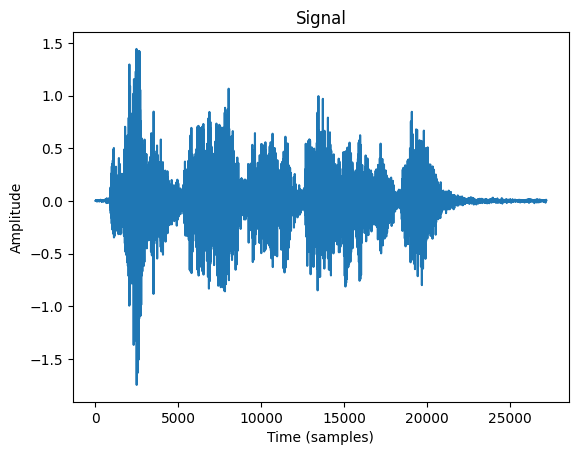

In [6]:
waveform_rir = aug(waveform)
show_and_play_signal(waveform_rir, sample_rate)

In [7]:
from augmentations import RandomBackgroundNoise


noiser = RandomBackgroundNoise(
    noise_root="/media/klig/disk/datasets/arabic-natural-audio",
    sample_rate=8000,
    segment_size=waveform.shape[-1],
    bank_size=4,
    snr_dbs_range=[10, 20],
)

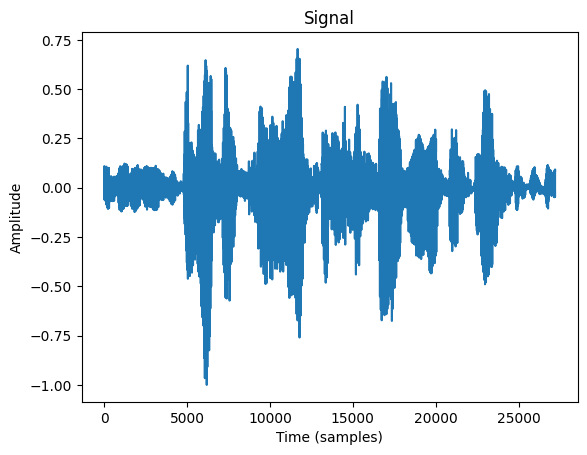

In [8]:
noisy = noiser(waveform)
show_and_play_signal(noisy, sample_rate)

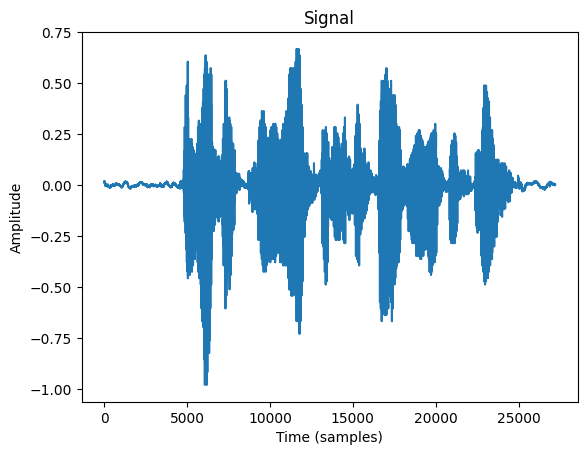

In [9]:
from augmentations import RandomEncoder


encoder = RandomEncoder(
    sample_rate=8000,
)

encoded = encoder(waveform)
show_and_play_signal(encoded, sample_rate)